<a href="https://www.kaggle.com/code/tayen1/nyc-taxi-duration?scriptVersionId=236914381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/tayen1/nyc-taxi-duration?scriptVersionId=235737872" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/tayen1/nyc-taxi-duration?scriptVersionId=235734476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

output_dir = '/kaggle/working/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_path_name = os.path.join(dirname, filename)
        print(data_path_name)
        with zipfile.ZipFile(data_path_name, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

print("Finish unzip")

for dirname, _, filenames in os.walk(output_dir):
    for filename in filenames:
        print(os.path.join(output_dir, filename))

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
Finish unzip
/kaggle/working/train.csv
/kaggle/working/test.csv
/kaggle/working/sample_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [3]:
test_df = pd.read_csv("/kaggle/working/test.csv")
train_df = pd.read_csv("/kaggle/working/train.csv")
sample_submission_df = pd.read_csv("/kaggle/working/sample_submission.csv")

# Data Exploration

In [4]:
train_df.shape

(1458644, 11)

In [5]:
test_df.shape

(625134, 9)

In [6]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [9]:
# add a column convert trip_duration sec to minutes
train_df['trip_duration_min'] = train_df['trip_duration'] / 60

In [10]:
train_df['trip_duration_hour'] = train_df['trip_duration_min'] / 60

In [11]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duration_min,trip_duration_hour
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.599154e+01,2.665256e-01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,8.729053e+01,1.454842e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.666667e-02,2.777778e-04
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,6.616667e+00,1.102778e-01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.103333e+01,1.838889e-01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,1.791667e+01,2.986111e-01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,5.877137e+04,9.795228e+02


## 1. Target Feature : trip_duration

In [12]:
trip_duration_min = train_df['trip_duration_min']
# Create 15-minute bins (0–480 mins = 8 hours)
bins = np.arange(0, 481, 15)
labels = [f"{i}-{i+15}" for i in bins[:-1]]

# Bin the data and count trips per interval
trip_counts = pd.cut(trip_duration_min, bins=bins, labels=labels, right=False).value_counts().sort_index()

# Create a summary DataFrame
trip_stats = pd.DataFrame({
    'Duration Interval (min)': trip_counts.index,
    'Trip Count': trip_counts.values
})

trip_stats


,Duration Interval (min),Trip Count
0,0-15,967595
1,15-30,377736
2,30-45,79176
3,45-60,21803
4,60-75,6969
5,75-90,2266
6,90-105,646
7,105-120,200
8,120-135,70
9,135-150,37


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


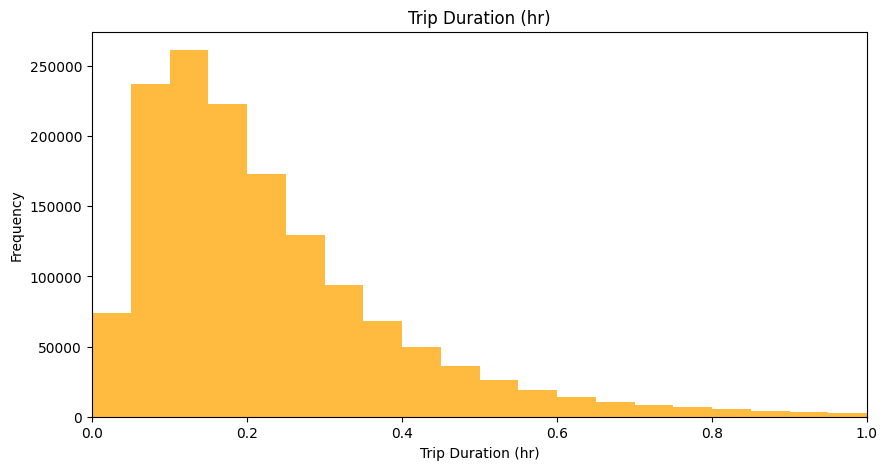

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['trip_duration_hour'], bins = 100,binwidth = 0.05, color='orange')
plt.title('Trip Duration (hr)')
plt.xlabel('Trip Duration (hr)')
plt.ylabel('Frequency')
plt.xlim(0,1)
#plt.ylim(0, 20000)
plt.show()

Observation : In this dataset, the target variable trip_duration is measured in seconds and is highly skewed — most trips are short, but a few take several hours (or more). To better visualize and model the data, we apply a logarithmic transformation.
"log_duration = log(Trip Duration + 1)"

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


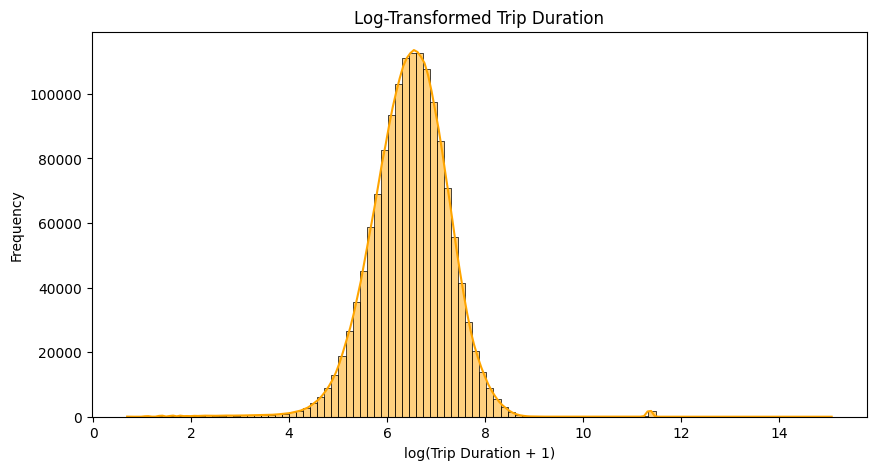

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(train_df['trip_duration']), bins=100, kde=True, color='orange')
plt.title('Log-Transformed Trip Duration')
plt.xlabel('log(Trip Duration + 1)')
plt.ylabel('Frequency')
plt.show()

Observation : log(Trip Duration Time + 1) concentrated in 5 to 8 which equal to 2.5 to 49.7 minutes.

 - log(Trip Duration Time + 1) = 5 = ~147 sec = ~2.5 minutes
 - log(Trip Duration Time + 1) = 6 = ~403 sec = ~6.7 minutes
 - log(Trip Duration Time + 1) = 7 = ~1096 sec = ~18.3 minutes
 - log(Trip Duration Time + 1) = 8 = ~2980 sec = ~49.7 minutes

## 2.  Pickup Time (Hour and Day) :

In [15]:
# convert pickup_datetime to datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_day'] = train_df['pickup_datetime'].dt.dayofweek

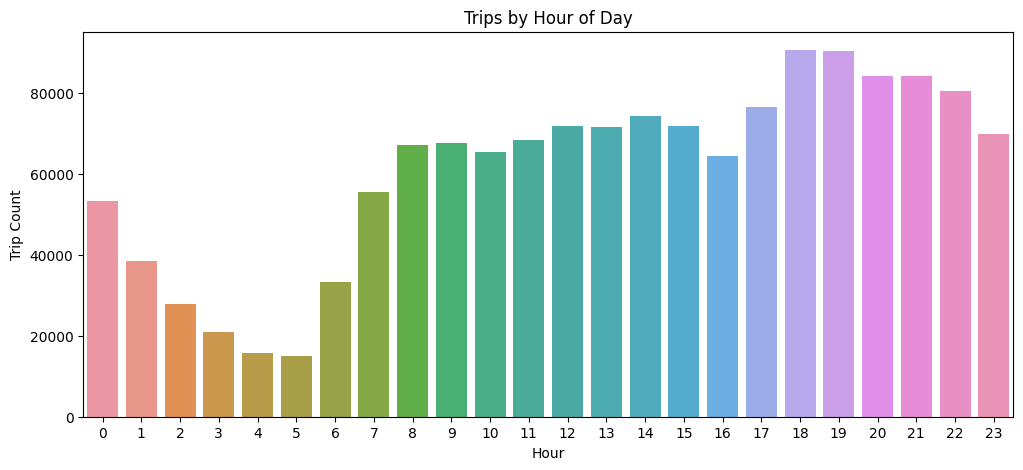

In [16]:
plt.figure(figsize=(12,5))
sns.countplot(x='pickup_hour', data=train_df)
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Trip Count')
plt.show()

Observation : 18 to 22 has highest Trip Count and it also represent the work finish time.

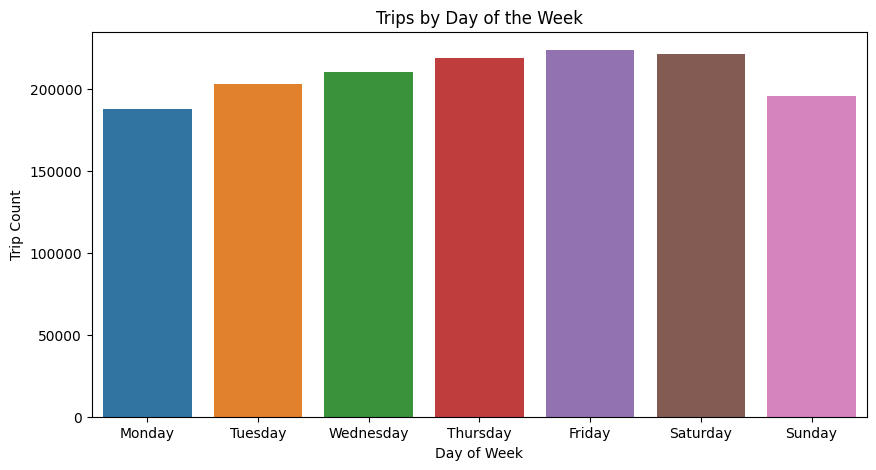

In [17]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_df['pickup_day_name'] = train_df['pickup_day'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
plt.figure(figsize=(10,5))
sns.countplot(x='pickup_day_name', data=train_df, order=weekday_labels)
plt.title('Trips by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Count')
plt.show()

Observation : Thursday to Saturday has the more Trip Count.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


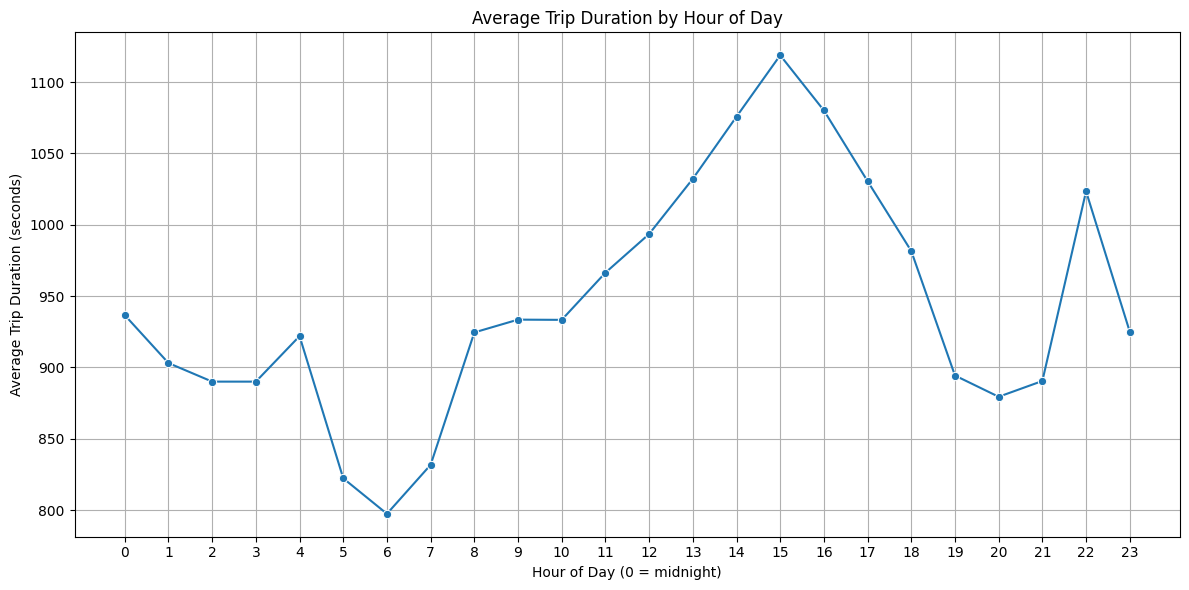

In [18]:
hourly_avg = train_df.groupby('pickup_hour')['trip_duration'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o')

plt.xticks(range(0, 24))  # X-axis from 0 to 23
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Average Trip Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


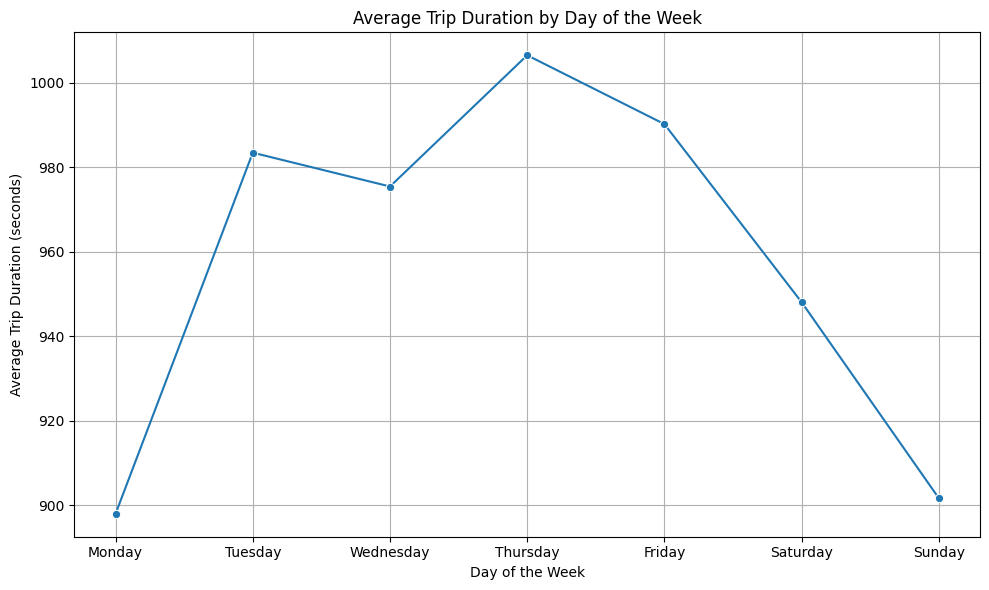

In [19]:
avg_by_day = train_df.groupby('pickup_day_name')['trip_duration'].mean()

avg_by_day = avg_by_day.reindex(weekday_labels)
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_by_day.index, y=avg_by_day.values, marker='o')

plt.title('Average Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trip Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Geospatial Features (latitude and longtitude) :
New York City's latitude and longtitude cooridnates are 40.730610, -73.935242.

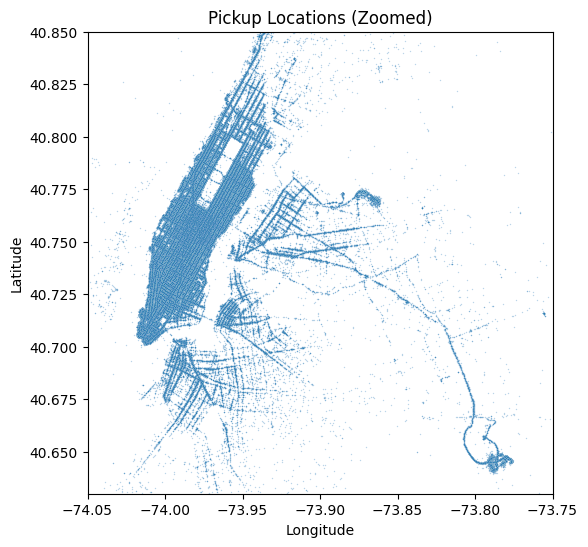

In [20]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=train_df['pickup_longitude'], y=train_df['pickup_latitude'], s=1, alpha=0.3)
plt.title('Pickup Locations (Zoomed)')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Observation :
- Northwest : Midtown and Downtown Manhattan. This area has high taxi activity and clear street system.
- Southeast : JFK airport. There is a long curve path to the airport.

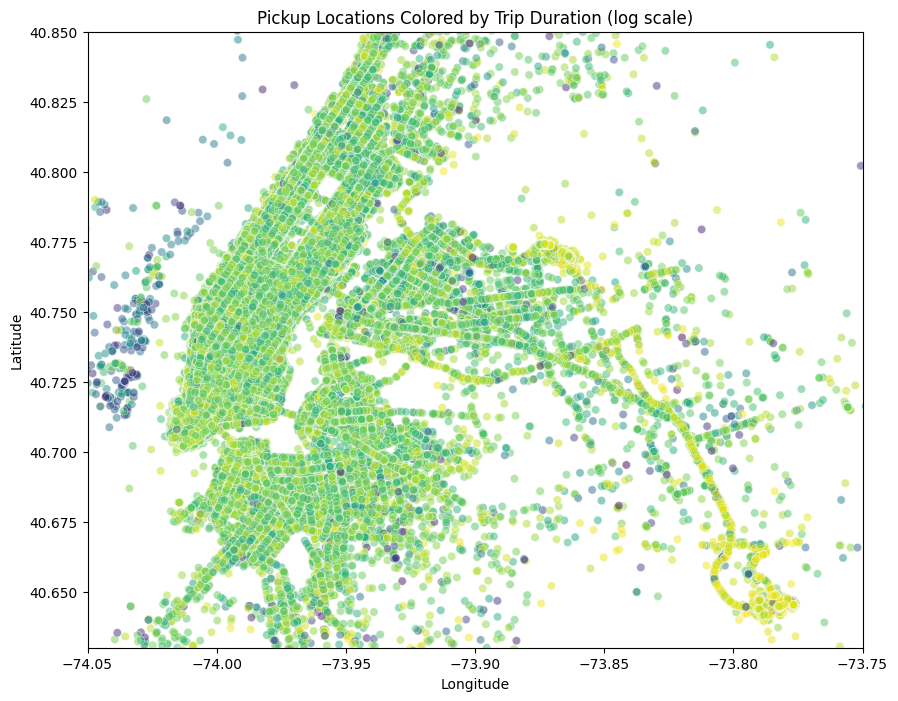

In [21]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train_df[train_df['trip_duration'] < 3600],  # remove extreme outliers
    x='pickup_longitude',
    y='pickup_latitude',
    hue=np.log1p(train_df[train_df['trip_duration'] < 3600]['trip_duration']),
    palette='viridis',
    alpha=0.5,
    legend=False
)
plt.title('Pickup Locations Colored by Trip Duration (log scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

Observation :
- Yellow = longer trip duration, Green = shorter trip duration
- The yellow dots are at the bottom right which is JFK International Airport. These pickups tend to have longer trip durations, which makes sense, because taxis from JFK often go into Manhattan or outer boroughs (long distances).
- The green dots are at center left which is Manhattan, likely shorter trips, possibly due to high taxi density and traffic.

## 4. Passenager count

In [22]:
trip_counts = train_df['passenger_count'].value_counts().sort_index()
trip_counts

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64

Observation :
1. There are 60 rows where passenger_count == 0 which means 60 trips recorded with 0 passengers. It does not make sense.

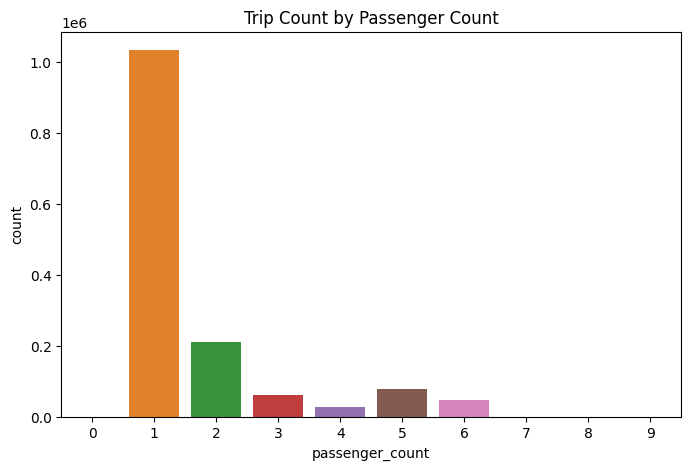

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='passenger_count', data=train_df)
plt.title('Trip Count by Passenger Count')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


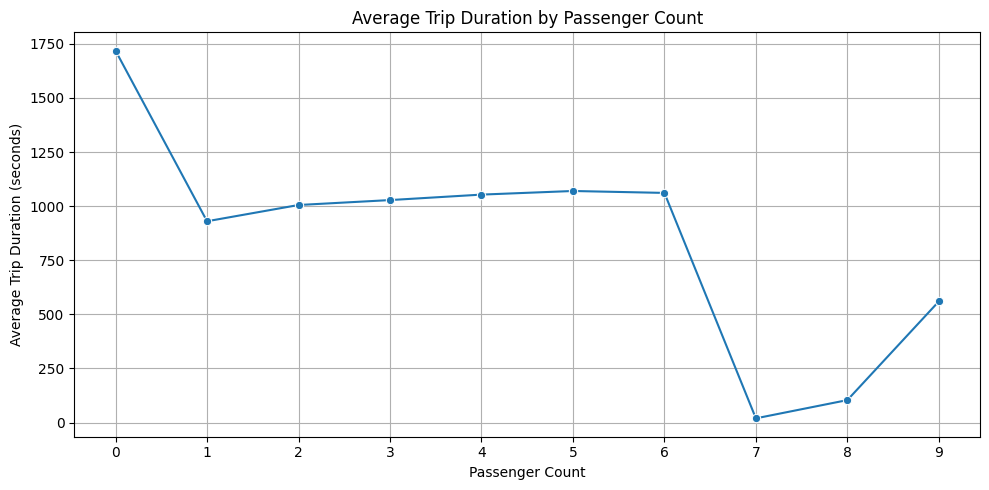

In [24]:
passenger_avg = train_df.groupby('passenger_count')['trip_duration'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=passenger_avg.index, y=passenger_avg.values, marker='o')

plt.title('Average Trip Duration by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(passenger_avg.index)  # Ensure all categories show
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Vendor_id

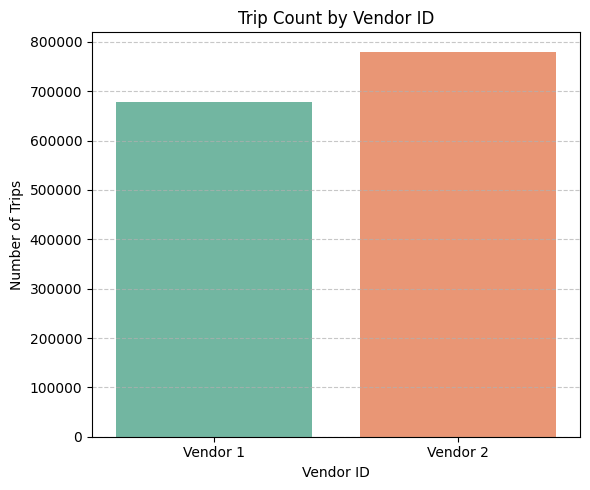

In [25]:
plt.figure(figsize=(6, 5))
sns.countplot(x='vendor_id', data=train_df, palette='Set2')

plt.title('Trip Count by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Number of Trips')
plt.xticks([0, 1], labels=['Vendor 1', 'Vendor 2'])  # optional custom labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

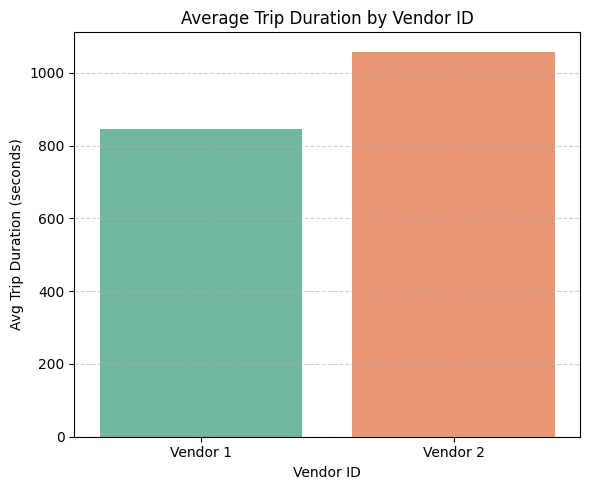

In [26]:
vendor_avg_duration = train_df.groupby('vendor_id')['trip_duration'].mean()

plt.figure(figsize=(6, 5))
sns.barplot(x=vendor_avg_duration.index, y=vendor_avg_duration.values, palette='Set2')

plt.title('Average Trip Duration by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Avg Trip Duration (seconds)')
plt.xticks([0, 1], labels=['Vendor 1', 'Vendor 2'])  # Optional: label mapping
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Observation :
Vendor 2 has more trip count and also it tend to has longer trip duration.

## 6. Store and fwd flag
- N :  transmitted to the server in real time 
- Y :  stored temporarily.

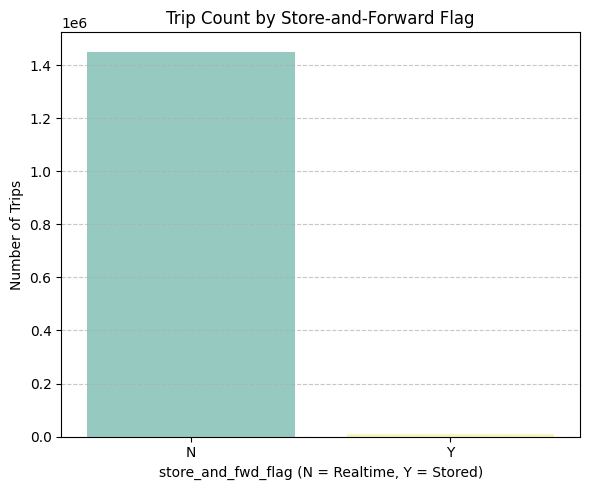

In [27]:
plt.figure(figsize=(6, 5))
sns.countplot(x='store_and_fwd_flag', data=train_df, palette='Set3')

plt.title('Trip Count by Store-and-Forward Flag')
plt.xlabel('store_and_fwd_flag (N = Realtime, Y = Stored)')
plt.ylabel('Number of Trips')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

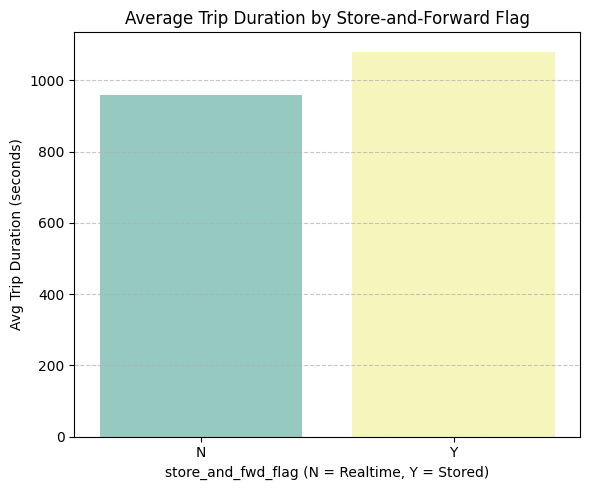

In [28]:
avg_duration = train_df.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.figure(figsize=(6, 5))
sns.barplot(x=avg_duration.index, y=avg_duration.values, palette='Set3')

plt.title('Average Trip Duration by Store-and-Forward Flag')
plt.xlabel('store_and_fwd_flag (N = Realtime, Y = Stored)')
plt.ylabel('Avg Trip Duration (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observation : 
 - Most of the trip is transmitted to the server in real time.
 - Trips marked as Y (stored) have a higher average trip duration than those marked N.
 - Longer trips are more likely to leave real-time coverage zones, such as Airport trips, Tunnels or bridges, Outer boroughs with weaker signal.

In [29]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
trip_duration_min     0
trip_duration_hour    0
pickup_hour           0
pickup_day            0
pickup_day_name       0
dtype: int64
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64
0
0


# Train and evaluate models

## Randam Forest

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,median_absolute_error,r2_score,explained_variance_score

In [31]:
train_rf_df = train_df.copy()
test_rf_df = test_df.copy()

In [32]:
#Obtain the day of the week and the hour of pickup from the train data
train_rf_df['pickup_datetime'] = pd.to_datetime(train_rf_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train_rf_df['pickup_week'] = train_rf_df['pickup_datetime'].dt.day_name()
train_rf_df['pickup_hour'] = train_rf_df['pickup_datetime'].dt.hour
#Obtain the day of the week and the hour of pickup from the test data
test_rf_df['pickup_datetime'] = pd.to_datetime(test_rf_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_rf_df['pickup_week'] = test_rf_df['pickup_datetime'].dt.day_name()
test_rf_df['pickup_hour'] = test_rf_df['pickup_datetime'].dt.hour

In [33]:
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0
    q = np.radians(lat1)
    w = np.radians(lat2)
    e = np.radians(lat2 - lat1)
    r = np.radians(lon2 - lon1)
    
    a = np.sin(e/2.0)**2 + np.cos(q) * np.cos(w) * np.sin(r/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [34]:
#Get the distace from point to point
train_rf_df['distance_km'] = haversine_np(train_rf_df['pickup_latitude'],
    train_rf_df['pickup_longitude'],
    train_rf_df['dropoff_latitude'],
    train_rf_df['dropoff_longitude'])
#Get the distace from point to point
test_rf_df['distance_km'] = haversine_np(test_rf_df['pickup_latitude'],
    test_rf_df['pickup_longitude'],
    test_rf_df['dropoff_latitude'],
    test_rf_df['dropoff_longitude'])

In [35]:
train_rf_df.head()
test_rf_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_week,pickup_hour,distance_km
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,Thursday,23,2.746426
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,Thursday,23,2.759239
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,Thursday,23,1.306155
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,Thursday,23,5.269088
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,Thursday,23,0.960842


In [36]:
#Observe datatype of the columns
print(train_rf_df.dtypes)
print(test_rf_df.dtypes)

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime              object
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
trip_duration_min            float64
trip_duration_hour           float64
pickup_hour                    int32
pickup_day                     int32
pickup_day_name               object
pickup_week                   object
distance_km                  float64
dtype: object
id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag      

In [37]:
#Define the independent variables in categories 
cat_cols = ['vendor_id', 'store_and_fwd_flag', 'pickup_week']
num_cols   = ['passenger_count','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','pickup_hour', 'distance_km']

In [38]:

train_rf_df['log_trip_duration'] = np.log1p(train_rf_df['trip_duration'])

In [39]:
X = train_rf_df[num_cols + cat_cols]
y = train_rf_df['log_trip_duration']
X_test  = test_rf_df[num_cols + cat_cols]
x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [40]:
#Set up a preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[ ('num', StandardScaler(), num_cols),('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)])

In [41]:
X_train_proc = preprocessor.fit_transform(x_train)
X_test_proc  = preprocessor.transform(x_val)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
RF = RandomForestRegressor(n_estimators=50, random_state=42)
RF.fit(X_train_proc, y_train)
P_RF = RF.predict(X_test_proc)



In [43]:
metrics = {
    'MSE (Actual value)'      : mean_squared_error(np.expm1(y_val), np.expm1(P_RF)),
    'MAPE'     : mean_absolute_percentage_error(y_val, P_RF),
    'MedianAE' : median_absolute_error(y_val, P_RF),
    'R2'       : r2_score(y_val, P_RF),
    'ExplVar'  : explained_variance_score(y_val, P_RF),
    "rmsle" : np.sqrt(mean_squared_error(y_val, P_RF ))
}
for name, val in metrics.items():
    print(f"{name:7s}: {val:.4f}")

MSE (Actual value): 10255484.6966
MAPE   : 0.0428
MedianAE: 0.1875
R2     : 0.7355
ExplVar: 0.7356
rmsle  : 0.4097


## XGBoost

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [45]:
# Encode store_and_fwd_flag 
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

In [46]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_min,trip_duration_hour,pickup_hour,pickup_day,pickup_day_name
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,7.583333,0.126389,17,0,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,11.050000,0.184167,0,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,35.400000,0.590000,11,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,7.150000,0.119167,19,2,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,7.250000,0.120833,13,5,Saturday


In [47]:
# only choose the features, avoid the feature that for EDA
features = [
    'vendor_id', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'store_and_fwd_flag',
    'pickup_hour', 'pickup_day'
]

In [48]:
# target use raw and log
X = train_df[features]
y_raw = train_df['trip_duration']
y_log = np.log1p(train_df['trip_duration'])

In [49]:
#split train and test
X_train, X_valid, y_train_raw, y_valid_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)
_, _, y_train_log, y_valid_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [50]:
# bulid the model
model_raw = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
model_log = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)

In [51]:
# train model
model_raw.fit(X_train, y_train_raw)
model_log.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
# predict
pred_raw = model_raw.predict(X_valid)
pred_log = model_log.predict(X_valid) 

In [53]:
from sklearn.metrics import mean_squared_error
# Clip predictions to avoid negatives
pred_raw_clipped = np.maximum(pred_raw, 0)

# Now calculate RMSLE safely
rmsle＿raw = mean_squared_error(np.log1p(y_valid_raw), np.log1p(pred_raw_clipped), squared=False)



rmsle_log = mean_squared_error(y_valid_log, pred_log, squared=False)

print(f"RMSLE: {rmsle_raw:.4f}")
print(f"RMSLE from log-transformed model: {rmsle_log:.4f}")

RMSLE: 0.6420
RMSLE from log-transformed model: 0.4454


Observation: RMSE with log1p transform has better RMSE which is 3203s but it still way too large. So we are going to do more feature engineering.

## Feature Engineering
 - harversine distance
 - manhattan distance
 - rush hour
 - weekend

### 1. Harversine distance

In [54]:
# harversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = R * c
    return km

train_df['haversine_distance'] = haversine_distance(
    train_df['pickup_latitude'],
    train_df['pickup_longitude'],
    train_df['dropoff_latitude'],
    train_df['dropoff_longitude']
)

### 2. Manhattan distance

In [55]:
train_df['manhattan_distance'] = (
    np.abs(train_df['dropoff_longitude'] - train_df['pickup_longitude']) +
    np.abs(train_df['dropoff_latitude'] - train_df['pickup_latitude'])
)

### 3. Rush hour

In [56]:
# rush hour : 7-9am and 4-7pm
train_df['rush_hour'] = train_df['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

### 4. Weekend

In [57]:
train_df['weekend'] = train_df['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

In [58]:
features = [
    'vendor_id', 'passenger_count', 'store_and_fwd_flag',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'pickup_hour', 'pickup_day',
    'haversine_distance', 'manhattan_distance',
    'rush_hour', 'weekend'
]

In [59]:
X = train_df[features]
y = np.log1p(train_df['trip_duration'])

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [62]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [63]:
y_pred = model.predict(X_valid)

In [64]:
rmsle = mean_squared_error(y_valid, y_pred, squared=False)

print(f"RMSLE after Feature Engineering: {rmsle:.4f}")

RMSLE after Feature Engineering: 0.4155


Observation: RMSE after Feature Enginnering only improve 7 sec, so then try to remove some outliers.

## Handle Outliers

In [65]:
train_df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [66]:
# Remove trip duration lower than 10 sec and also higher than 3600 sec 
lower_bound = 10
upper_bound = 3600

train_df_cleaned = train_df[(train_df['trip_duration'] >= lower_bound) & (train_df['trip_duration'] <= upper_bound)]

print(f"Before handling outliers, there are {train_df.shape[0]} rows. After handling outliers, there are {train_df_cleaned.shape[0]} rows.")

Before handling outliers, there are 1458644 rows. After handling outliers, there are 1444343 rows.


Observation : Remove 14301 rows which is 10% of the dataset.

In [67]:
features = [
    'vendor_id', 'passenger_count', 'store_and_fwd_flag',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'pickup_hour', 'pickup_day',
    'haversine_distance', 'manhattan_distance',
    'rush_hour', 'weekend'
]

In [68]:
X = train_df_cleaned[features]
y = np.log1p(train_df_cleaned['trip_duration'])

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [71]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [72]:
y_pred = model.predict(X_valid)

In [73]:
rmsle = mean_squared_error(y_valid, y_pred, squared=False)

print(f"RMSLE after removing outliers: {rmsle:.4f}")

RMSLE after removing outliers: 0.3552


In [74]:
# 1. Data Preprocessing

# store_and_fwd_flag: N=0, Y=1
test_df['store_and_fwd_flag'] = test_df['store_and_fwd_flag'].map({'N':0, 'Y':1})

# pickup_datetime ➔  pickup_hour, pickup_day
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_day'] = test_df['pickup_datetime'].dt.dayofweek

# haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

test_df['haversine_distance'] = haversine_distance(
    test_df['pickup_latitude'],
    test_df['pickup_longitude'],
    test_df['dropoff_latitude'],
    test_df['dropoff_longitude']
)

# manhattan distance
test_df['manhattan_distance'] = (
    np.abs(test_df['dropoff_longitude'] - test_df['pickup_longitude']) +
    np.abs(test_df['dropoff_latitude'] - test_df['pickup_latitude'])
)

# rush_hour, weekend
test_df['rush_hour'] = test_df['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)
test_df['weekend'] = test_df['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

# 2. choose features same as train data
features = [
    'vendor_id', 'passenger_count', 'store_and_fwd_flag',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'pickup_hour', 'pickup_day',
    'haversine_distance', 'manhattan_distance',
    'rush_hour', 'weekend'
]

X_test = test_df[features]

# 3. use the final model to predict
test_preds_log = model.predict(X_test)

# log convert back 
test_preds = np.expm1(test_preds_log)

# in case there is negative value
test_preds = np.clip(test_preds, 1, None)

# 4. submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'], 
    'trip_duration': test_preds
})

# 5. csv file
submission.to_csv('submission.csv', index=False)

print("✅ Successfully created submission.csv!")


✅ Successfully created submission.csv!
